In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import *
from tqdm import tqdm
from Distribution import Normal, Gamma
from Model import TranslatedWeibullModel, ReparametrizedLogNormalModel, ReparametrizedGammaModel
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
def display(dico,burnin=0,true_par=[]):
    par_names = list(dico["chains"].keys())
    
    f,ax= plt.subplots(2,len(par_names),figsize=(20,10))
    for i,par_name in enumerate(par_names):
        ax[0,i].plot(dico["chains"][par_name][burnin:])
        ax[0,i].set_title(par_name)
        sns.kdeplot(dico["chains"][par_name][burnin:],ax=ax[1,i])
        if true_par!=[]:
            ax[0,i].axhline(true_par[i],color="red")
            ax[1,i].axvline(true_par[i],color="red")
    plt.show()
    

# Import data 

## Contes

In [47]:
filo=pd.read_csv('./data/FILO2020_DISP_COM.csv',sep=';')
col=list(filo.columns)
for i in range(len(col)):
    col[i]=col[i].replace("20","")
print(col)
filo.rename(columns=dict(zip(filo.columns,col)),inplace=True)

/Users/antoineluciano/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['CODGEO', 'NBMEN', 'NBPERS', 'NBUC', 'Q1', 'Q2', 'Q3', 'Q3_Q1', 'D1', 'D2', 'D3', 'D4', 'D6', 'D7', 'D8', 'D9', 'RD', 'S80S', 'GI', 'PACT', 'PTSA', 'PCHO', 'PBEN', 'PPEN', 'PPAT', 'PPSOC', 'PPFAM', 'PPMINI', 'PPLOGT', 'PIMPOT', 'AGE1Q1', 'AGE1Q2', 'AGE1Q3', 'AGE1Q3_Q1', 'AGE1D1', 'AGE1D2', 'AGE1D3', 'AGE1D4', 'AGE1D6', 'AGE1D7', 'AGE1D8', 'AGE1D9', 'AGE1RD', 'AGE1S80S', 'AGE1GI', 'AGE1PACT', 'AGE1PTSA', 'AGE1PCHO', 'AGE1PBEN', 'AGE1PPEN', 'AGE1PPAT', 'AGE1PPSOC', 'AGE1PPFAM', 'AGE1PPMINI', 'AGE1PPLOGT', 'AGE1PIMPOT', 'AGE2Q1', 'AGE2Q2', 'AGE2Q3', 'AGE2Q3_Q1', 'AGE2D1', 'AGE2D2', 'AGE2D3', 'AGE2D4', 'AGE2D6', 'AGE2D7', 'AGE2D8', 'AGE2D9', 'AGE2RD', 'AGE2S80S', 'AGE2GI', 'AGE2PACT', 'AGE2PTSA', 'AGE2PCHO', 'AGE2PBEN', 'AGE2PPEN', 'AGE2PPAT', 'AGE2PPSOC', 'AGE2PPFAM', 'AGE2PPMINI', 'AGE2PPLOGT', 'AGE2PIMPOT', 'AGE3Q1', 'AGE3Q2', 'AGE3Q3', 'AGE3Q3_Q1', 'AGE3D1', 'AGE3D2', 'AGE3D3', 'AGE3D4', 'AGE3D6', 'AGE3D7', 'AGE3D8', 'AGE3D9', 'AGE3RD', 'AGE3S80S', 'AGE3GI', 'AGE3PACT', 'AGE3PTSA', 'A

In [48]:
filo2 = filo[~filo['NBMEN'].str.contains('s')]
filo2 = filo2[~filo2['NBMEN'].str.contains('nd')]
filo2 = filo2[~filo2['D1'].str.contains('s')]
filo3 = filo2[~filo2['CODGEO'].astype(str).str.startswith(('2A', '2B'))]
filo3.shape

(5324, 732)

In [49]:
contes = filo.iloc[1917]

N_contes = int(contes["NBMEN"])
Q_contes = np.array(contes[["D1","D2","Q1","D3","D4","Q2","D6","D7","Q3","D8","D9"]]).astype(float)
P=np.array([.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9])
N_contes,Q_contes


(2899,
 array([13510., 17170., 18640., 19870., 22320., 24290., 26500., 28840.,
        30220., 31960., 37720.]))

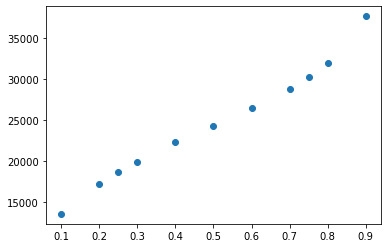

In [6]:
plt.scatter(P,Q_contes)

# Plot Weibull Contes

In [50]:
P = np.array([.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9])

In [45]:
P_list = np.array([[3,7],[2,5,8],[1,4,6,9],[0,1,2,3,4,5,6,7,8,9,10]])

for p in P_list:
    print(P[p]),print(np.linspace(0,1,len(p)+2)[1:-1])

[0.3 0.7]
[0.33333333 0.66666667]
[0.25 0.5  0.75]
[0.25 0.5  0.75]
[0.2 0.4 0.6 0.8]
[0.2 0.4 0.6 0.8]
[0.1  0.2  0.25 0.3  0.4  0.5  0.6  0.7  0.75 0.8  0.9 ]
[0.08333333 0.16666667 0.25       0.33333333 0.41666667 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667]


/Users/antoineluciano/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [51]:
loc = Gamma(10000,10)
scale = Gamma(1000,10)
shape = Gamma(10,10)

trans_weibull = TranslatedWeibullModel(loc=loc,scale=scale,shape=shape)

P_list = np.array([[3,7],[2,5,8],[1,4,6,9],[0,1,2,3,4,5,6,7,8,9,10]])
MCMC_obs = []
for p in P_list:
    
    MCMC_obs.append(trans_weibull.Gibbs_Quantile(201000,N_contes,Q_contes[p],P[p],std_prop_dict={"loc":100,"scale":300,"shape":.06},std_prop_quantile=0.01,verbose=True,List_X=True))


/Users/antoineluciano/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
  0%|          | 0/201000 [00:00<?, ?it/s]

100%|██████████| 201000/201000 [21:45<00:00, 154.01it/s]


Acceptance rate of the order statistics (870) = 75.84%
Acceptance rate of the order statistics (2029) = 76.02%
Acceptation rates MH : loc = 29.48% scale = 55.78% shape = 36.12% 


100%|██████████| 201000/201000 [21:46<00:00, 153.86it/s]


Acceptance rate of the order statistics (725) = 77.47%
Acceptance rate of the order statistics (2174) = 76.88%
Acceptation rates MH : loc = 69.70% scale = 52.99% shape = 48.86% 


100%|██████████| 201000/201000 [27:02<00:00, 123.89it/s]


Acceptance rate of the order statistics (580) = 78.07%
Acceptance rate of the order statistics (1160) = 68.88%
Acceptance rate of the order statistics (1739) = 68.51%
Acceptance rate of the order statistics (2319) = 77.54%
Acceptation rates MH : loc = 74.61% scale = 53.20% shape = 51.99% 


100%|██████████| 201000/201000 [44:20<00:00, 75.54it/s] 


Acceptance rate of the order statistics (290) = 75.95%
Acceptance rate of the order statistics (580) = 79.15%
Acceptance rate of the order statistics (725) = 77.90%
Acceptance rate of the order statistics (870) = 75.81%
Acceptance rate of the order statistics (1160) = 67.44%
Acceptance rate of the order statistics (1739) = 67.89%
Acceptance rate of the order statistics (2029) = 74.00%
Acceptance rate of the order statistics (2174) = 76.51%
Acceptance rate of the order statistics (2319) = 79.15%
Acceptance rate of the order statistics (2609) = 76.51%
Acceptation rates MH : loc = 75.07% scale = 55.56% shape = 50.66% 


In [54]:
sns.color_palette("mako")

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

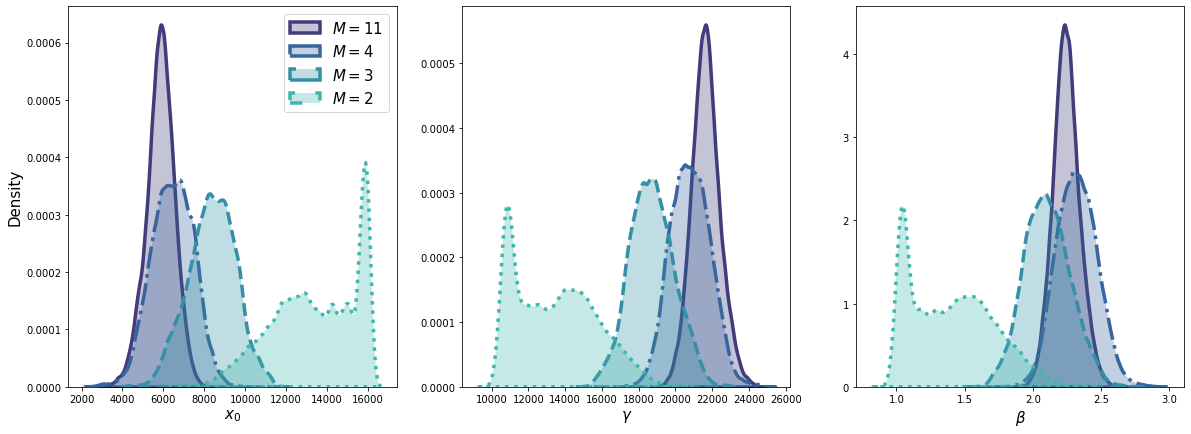

In [67]:
f,ax=plt.subplots(1,3,figsize=(20,7))
color = [sns.color_palette("mako")[i] for i in [1,2,3,4]]
linestyle = ["dotted","--","-.","-"][::-1]
burnin = 1000
lw = 3.5
fs=15
post_list = MCMC_obs[::-1]
M_list = [len(P) for P in P_list][::-1]
alpha=.3
for i,post in enumerate(post_list):

    sns.kdeplot(post["chains"]["loc"][burnin:],ax=ax[0],label = "$M = {}$".format(M_list[i]),fill=True,alpha=alpha,linestyle=linestyle[i],linewidth=lw,color=color[i])
    sns.kdeplot(post["chains"]["scale"][burnin:],ax=ax[1],label = "$M = {}$".format(M_list[i]),fill=True,alpha=alpha,linestyle=linestyle[i],linewidth=lw, color=color[i])
    sns.kdeplot(post["chains"]["shape"][burnin:],ax=ax[2],label = "$M = {}$".format(M_list[i]),fill=True,alpha=alpha,linestyle=linestyle[i],linewidth=lw, color=color[i])
ax[0].set_xlabel("$x_0$",fontsize=fs)
ax[0].set_ylabel("Density",fontsize=fs)
ax[1].set_xlabel("$\gamma$",fontsize=fs)
ax[1].set_ylabel("",fontsize=0)
ax[2].set_xlabel("$\\beta$",fontsize=fs)
ax[2].set_ylabel("",fontsize=0)

ax[0].legend(fontsize=fs)
plt.savefig("Fig8.png",format = "png", bbox_inches = 'tight',dpi=500)
plt.savefig("Fig8.pdf",format = "pdf", bbox_inches = 'tight',dpi=500)
plt.show()

# Bayesian model choice

## Reparametrized LogNormal

In [9]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

lognormm = ReparametrizedLogNormalModel(mean,std)


Contes_repar_ln = lognormm.Gibbs_Quantile(100000,N_contes,Q_contes,P,std_prop_dict={"mean":500,"std":500},std_prop_quantile=.05, List_X=True)

100%|██████████| 100000/100000 [19:29<00:00, 85.49it/s]


Acceptance rate of the order statistics (290) = 57.42%
Acceptance rate of the order statistics (580) = 60.75%
Acceptance rate of the order statistics (725) = 59.45%
Acceptance rate of the order statistics (870) = 58.38%
Acceptance rate of the order statistics (1160) = 54.49%
Acceptance rate of the order statistics (1739) = 54.39%
Acceptance rate of the order statistics (2029) = 55.96%
Acceptance rate of the order statistics (2174) = 56.47%
Acceptance rate of the order statistics (2319) = 57.74%
Acceptance rate of the order statistics (2609) = 57.76%
Acceptation rates MH : mean = 34.00% std = 32.69% 


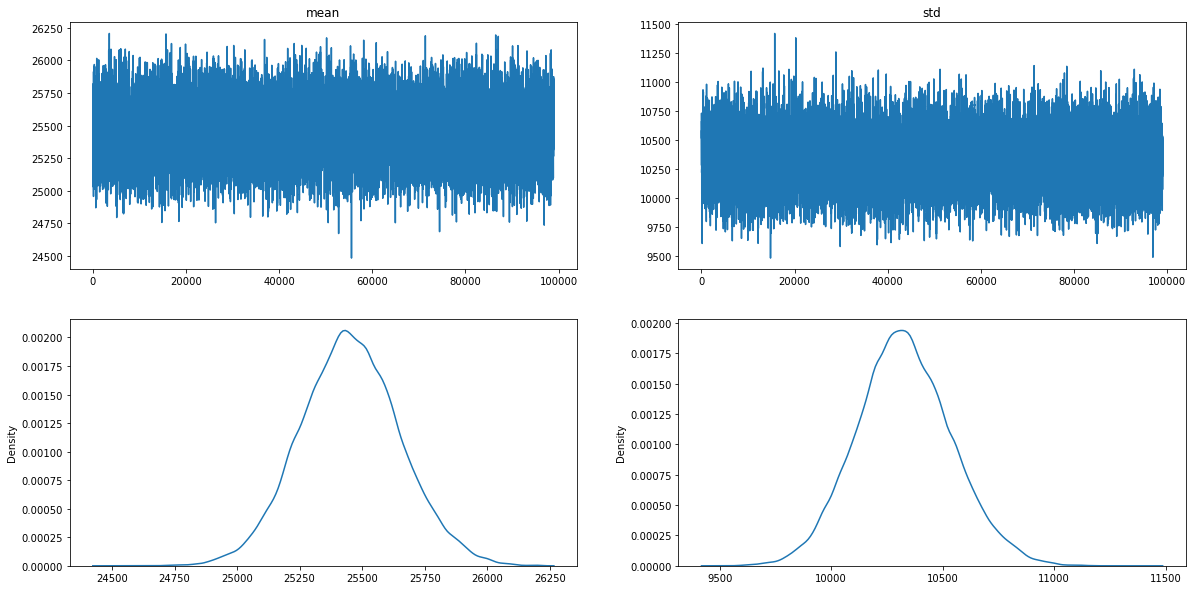

In [10]:
display(Contes_repar_ln,burnin=1000)

## Reparametrized Gamma 

In [11]:

mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

trans_gamma = ReparametrizedGammaModel(mean,std)


Contes_repar_g = trans_gamma.Gibbs_Quantile(100000,N_contes,Q_contes,P,std_prop_dict={"mean":500,"std":500},std_prop_quantile=.05, List_X=True)

  0%|          | 0/100000 [00:00<?, ?it/s]

/Users/antoineluciano/Documents/Recherche/Insufficient-Gibbs-Sampling/src/InsufficientGibbs/Model.py:224: RuntimeWarning: invalid value encountered in double_scalars
  ratio = np.exp(proposed_llikelihood - current_llikelihood + proposed_lprior - current_lprior)
100%|██████████| 100000/100000 [19:55<00:00, 83.62it/s]


Acceptance rate of the order statistics (290) = 57.57%
Acceptance rate of the order statistics (580) = 59.97%
Acceptance rate of the order statistics (725) = 59.17%
Acceptance rate of the order statistics (870) = 58.12%
Acceptance rate of the order statistics (1160) = 54.22%
Acceptance rate of the order statistics (1739) = 54.26%
Acceptance rate of the order statistics (2029) = 56.25%
Acceptance rate of the order statistics (2174) = 57.63%
Acceptance rate of the order statistics (2319) = 58.77%
Acceptance rate of the order statistics (2609) = 57.75%
Acceptation rates MH : mean = 35.25% std = 29.24% 


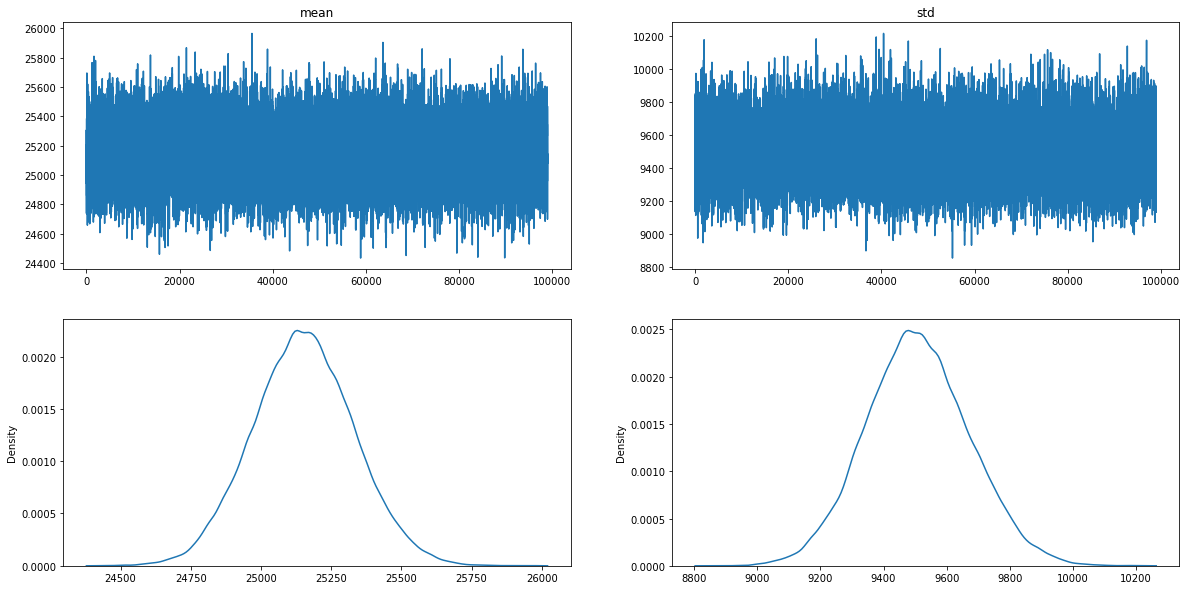

In [12]:
display(Contes_repar_g,burnin=1000)

## Comparison

10.06833755512887 0.3904143733848081
3594.6630912341166 6.996866361244234


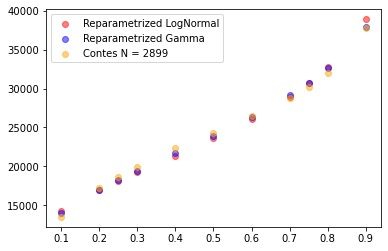

In [13]:
mean_gamma = np.mean(Contes_repar_g["chains"]["mean"][1000:])
std_gamma = np.mean(Contes_repar_g["chains"]["std"][1000:])
mean_ln = np.mean(Contes_repar_ln["chains"]["mean"][1000:])
std_ln = np.mean(Contes_repar_ln["chains"]["std"][1000:])

scale_ln,shape_ln = np.log(mean_ln**2/np.sqrt(mean_ln**2+std_ln**2)),np.sqrt(np.log(1+std_ln**2/mean_ln**2))
scale_gamma,shape_gamma = std_gamma**2/mean_gamma,(mean_gamma/std_gamma)**2
print(scale_ln,shape_ln)
print(scale_gamma,shape_gamma)

plt.scatter(P,lognorm(s=shape_ln, scale=np.exp(scale_ln), loc=0).ppf(P),color="red",label="Reparametrized LogNormal",alpha=.5)
plt.scatter(P,gamma(a=shape_gamma,scale=scale_gamma).ppf(P),color="blue",label="Reparametrized Gamma",alpha=.5)
plt.scatter(P,Q_contes,color = "orange",label="Contes N = {}".format(N_contes),alpha=.5)
plt.legend()


## Overlap verification

<AxesSubplot:ylabel='Density'>

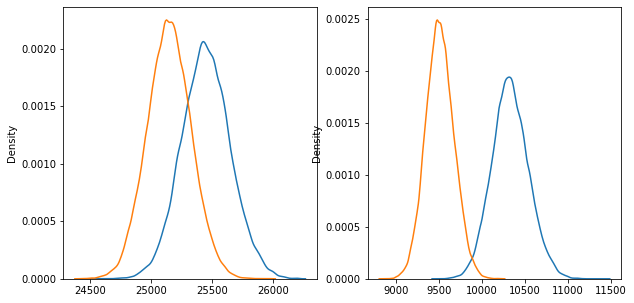

In [14]:
f,ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(Contes_repar_ln["chains"]["mean"][1000:],ax=ax[0],label="Reparametrized LogNormal")
sns.kdeplot(Contes_repar_g["chains"]["mean"][1000:],ax=ax[0],label="Reparametrized Gamma")
sns.kdeplot(Contes_repar_ln["chains"]["std"][1000:],ax=ax[1],label="Reparametrized LogNormal")
sns.kdeplot(Contes_repar_g["chains"]["std"][1000:],ax=ax[1],label="Reparametrized Gamma")


## Insufficient Bridge Sampling estimator 

In [15]:
from scipy.optimize import fixed_point
from scipy.special import logsumexp

def func_r_paper(r,l1,l2,lstar):
    return np.sum(np.exp(l2-lstar)/(np.exp(l2-lstar)+r))/np.sum(1/(np.exp(l1-lstar)+r))


def BF_paper(l1,l2):
    lstar = np.median(l1)
    r = fixed_point(func_r_paper,np.exp(-lstar),args=(l1,l2,lstar),maxiter=10000)
    BF = r*np.exp(lstar)
    return BF


def func_logBF_paper(logBF,l1,l2):
    num_j = np.array([logsumexp([0,logBF-l2[j]]) for j in range(len(l2))])
    den_i = np.array([logsumexp([l1[i],logBF]) for i in range(len(l1))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_paper(l1,l2):
    logBF = fixed_point(func_logBF_paper,1,args=(l1,l2),maxiter=10000)
    return logBF

def func_BF_dumb(BF,l1,l2):
    num = np.sum(np.exp(l2)/(np.exp(l2)+BF))
    den = np.sum(1/(np.exp(l1)+BF))
    return num/den
def BF_dumb(l1,l2):
    BF = fixed_point(func_BF_dumb,1,args=(l1,l2),maxiter=10000)
    return BF


In [16]:
from scipy.stats import lognorm,gamma

def logratio_ln_g(y,loc=0,mean=1,std=1):
    scale_ln,shape_ln = np.log((mean-loc)**2/np.sqrt((mean-loc)**2+std**2)),np.sqrt(np.log(1+std**2/(mean-loc)**2))
    scale_g,shape_g = std**2/(mean-loc),(mean-loc)**2/std**2
    res = np.sum(lognorm(s=shape_ln, scale=np.exp(scale_ln), loc=loc).logpdf(y)-gamma(a=shape_g,scale=scale_g,loc=loc).logpdf(y))
    if np.isnan(res):
        print("LN Scale : {} Shape : {}".format(scale_ln,shape_ln))
        print("Gamma Scale : {} Shape : {}".format(scale_g,shape_g))
        
    return res

In [17]:
mean_ln,std_ln = Contes_repar_ln["chains"]["mean"][1000:],Contes_repar_ln["chains"]["std"][1000:]
mean_g,std_g = Contes_repar_g["chains"]["mean"][1000:],Contes_repar_g["chains"]["std"][1000:]
Y_ln = Contes_repar_ln["X"][1001:]
Y_g = Contes_repar_g["X"][1001:]


In [18]:
l1 = [logratio_ln_g(Y_ln[i],mean=mean_ln[i],std=std_ln[i]) for i in range(len(Y_ln))]
l2 = [logratio_ln_g(Y_g[i],mean=mean_g[i],std=std_g[i]) for i in range(len(Y_g))]


In [19]:
logBF = logBF_paper(l1,l2)
print("log Bayes Factor : ",logBF)

log Bayes Factor :  -25.968588816161134


# Figure Weibull Simulated Data

In [4]:
loc = Normal(0,10)
scale = Gamma(2,2)
shape = Gamma(2,2)

trans_weibull = TranslatedWeibullModel(loc=loc,scale=scale,shape=shape)
true_loc,true_scale,true_shape=10,2,3
M_list = [2,3,4,5,9,11]
N = 1000
T = 201000
MCMC_sim = []
for M in M_list:
    P=np.linspace(0,1,M+2)[1:-1]
    Q=weibull_min(c=true_shape,loc=true_loc,scale=true_scale).ppf(P)
    MCMC_sim.append(trans_weibull.Gibbs_Quantile(T,N,Q,P,std_prop_dict={"loc":.05,"scale":.05,"shape":.2},std_prop_quantile=0.02,verbose=True,List_X=True))


100%|██████████| 201000/201000 [23:24<00:00, 143.07it/s]


Acceptation rates MH : loc = 35.74% scale = 44.45% shape = 45.74% 


100%|██████████| 201000/201000 [37:09<00:00, 90.17it/s]  


Acceptance rate of the order statistics (250) = 70.73%
Acceptance rate of the order statistics (500) = 72.94%
Acceptance rate of the order statistics (750) = 70.96%
Acceptation rates MH : loc = 42.20% scale = 43.90% shape = 49.46% 


100%|██████████| 201000/201000 [40:04<00:00, 83.59it/s] 


Acceptance rate of the order statistics (200) = 69.73%
Acceptance rate of the order statistics (400) = 72.46%
Acceptance rate of the order statistics (600) = 72.76%
Acceptance rate of the order statistics (800) = 69.89%
Acceptation rates MH : loc = 42.80% scale = 43.79% shape = 46.32% 


100%|██████████| 201000/201000 [41:30<00:00, 80.69it/s]  


Acceptance rate of the order statistics (167) = 76.69%
Acceptance rate of the order statistics (500) = 72.75%
Acceptance rate of the order statistics (833) = 77.12%
Acceptation rates MH : loc = 42.27% scale = 44.40% shape = 42.77% 


100%|██████████| 201000/201000 [1:02:49<00:00, 53.32it/s]


Acceptance rate of the order statistics (100) = 66.13%
Acceptance rate of the order statistics (200) = 69.83%
Acceptance rate of the order statistics (300) = 71.58%
Acceptance rate of the order statistics (400) = 72.68%
Acceptance rate of the order statistics (500) = 73.04%
Acceptance rate of the order statistics (600) = 73.05%
Acceptance rate of the order statistics (700) = 72.12%
Acceptance rate of the order statistics (800) = 70.08%
Acceptance rate of the order statistics (900) = 66.32%
Acceptation rates MH : loc = 42.33% scale = 44.53% shape = 40.54% 


100%|██████████| 201000/201000 [53:38<00:00, 62.46it/s] 


Acceptance rate of the order statistics (84) = 76.91%
Acceptance rate of the order statistics (167) = 76.85%
Acceptance rate of the order statistics (250) = 70.76%
Acceptance rate of the order statistics (417) = 69.25%
Acceptance rate of the order statistics (500) = 73.04%
Acceptance rate of the order statistics (583) = 69.32%
Acceptance rate of the order statistics (750) = 71.28%
Acceptance rate of the order statistics (833) = 77.27%
Acceptance rate of the order statistics (916) = 77.62%
Acceptation rates MH : loc = 42.13% scale = 44.60% shape = 40.45% 


In [8]:
MCMC_sim2 = [MCMC_sim[i] for i in [0,1,2,-1]]

In [33]:
sns.color_palette("mako")

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

In [37]:
colors = [sns.color_palette("mako")[i] for i in [0,2,4,5]]

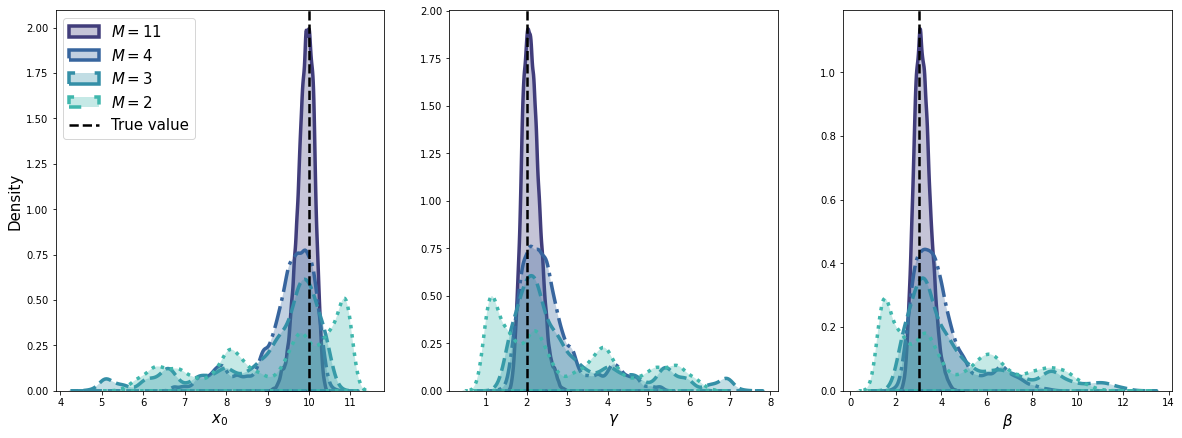

In [69]:
f,ax=plt.subplots(1,3,figsize=(20,7))
col = "black"
color = [sns.color_palette("mako")[i] for i in [1,2,3,4]]
linestyle = ["dotted","--","-.","-"][::-1]
burnin = 1000
lw = 3.5
fs=15
M_list = [2,3,4,11][::-1]

post_list = [MCMC_sim2[i]["chains"] for i in range(len(M_list))][::-1]
alpha=.3
for i,post in enumerate(post_list):
    sns.kdeplot(post["loc"][burnin:],ax=ax[0],label = "$M = {}$".format(M_list[i]),fill=True,alpha=alpha,linestyle=linestyle[i],linewidth=lw,color=color[i])
    sns.kdeplot(post["scale"][burnin:],ax=ax[1],label = "$M = {}$".format(M_list[i]),fill=True,alpha=alpha,linestyle=linestyle[i],linewidth=lw, color=color[i])
    sns.kdeplot(post["shape"][burnin:],ax=ax[2],label = "$M = {}$".format(M_list[i]),fill=True,alpha=alpha,linestyle=linestyle[i],linewidth=lw, color=color[i])
    

    
ax[0].set_xlabel("$x_0$",fontsize=fs)
ax[0].set_ylabel("Density",fontsize=fs)
ax[0].axvline(true_loc,color=col,label="True value", linestyle="--",linewidth=2.5)
ax[1].set_xlabel("$\gamma$",fontsize=fs)
ax[1].set_ylabel("",fontsize=0)
ax[1].axvline(true_scale,color=col,label="True value", linestyle="--",linewidth=2.5)
ax[2].set_xlabel("$\\beta$",fontsize=fs)
ax[2].set_ylabel("",fontsize=0)
ax[2].axvline(true_shape,color=col,label="True value", linestyle="--",linewidth=2.5)


ax[0].legend(fontsize=fs)
# plt.savefig("figure_E2.eps", format = "eps", bbox_inches = 'tight')
plt.savefig("FigE2.png", format = "png", bbox_inches = 'tight',dpi=500)
plt.savefig("FigE2.pdf", format = "pdf", bbox_inches = 'tight',dpi=500)

plt.show()

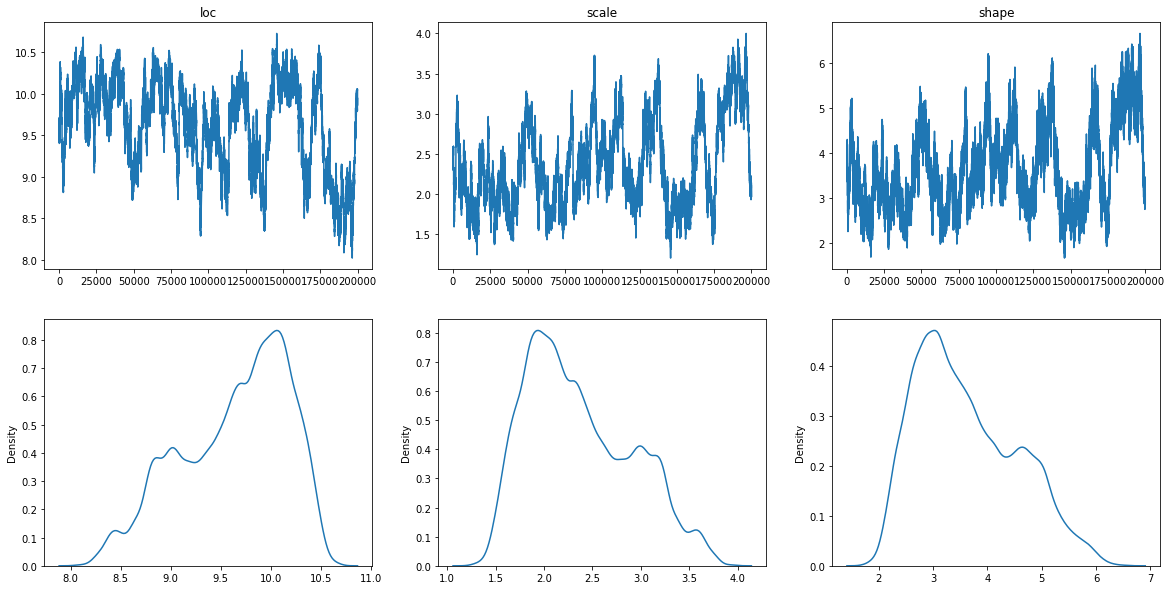

In [41]:
display(MCMC_sim2[2],burnin=1000)

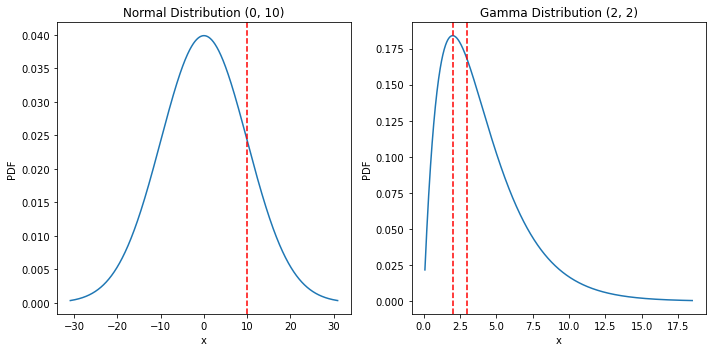

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# Define the range of x values
law1 = norm(loc=0, scale=10)
x1 = np.linspace(law1.ppf(0.001), law1.ppf(0.999), 1000)

law2 = gamma(a=2, scale=2)
x2 = np.linspace(law2.ppf(0.001), law2.ppf(0.999), 1000)


# Plot the PDFs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x1, law1.pdf(x1))
plt.axvline(10, color='r', linestyle='--')
plt.title('Normal Distribution (0, 10)')
plt.xlabel('x')
plt.ylabel('PDF')

plt.subplot(1, 2, 2)
plt.plot(x2, law2.pdf(x2))
plt.axvline(2, color='r', linestyle='--')
plt.axvline(3, color='r', linestyle='--')
plt.title('Gamma Distribution (2, 2)')
plt.xlabel('x')
plt.ylabel('PDF')

plt.tight_layout()
plt.show()
